# Atmosphere Models

In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

***
## Introduction

To support conceptual design of aircraft, several models of the Earth's atmosphere are accessible through CARPy.
Models include:

1. ISA1975, the International Standard Atmosphere as described in ISO 2533:1975.
2. MILHDBK310, a resource from the U.S. DoD describing several atmospheres in which conditions deviate unusually far from standard day conditions.
3. US1976, **not yet implemented**.
4. ObsAtmospherePerfect, for user-specified atmospheric profiles.

Atmospheric models are built in a manner that allows users to hotswap for other models - and provided that relevant methods are fully defined - produce drop-in replacements for ease of evaluation.

***
## 1) `ISA1975` objects

Start with relevant imports

In [2]:
from carpy.environment import ISA1975

# Create an atmosphere object
myatmosphere = ISA1975()

print(myatmosphere)

ISA1975(+0°C)


As can be seen above, we've instantiated an ISA atmosphere with a temperature offset of zero from standard day conditions at sea level.

The temperature offset can be set during instantiation time or in-situ:

In [3]:
myatmosphere.T_offset = 3

print("Atmosphere (modified).......", myatmosphere)
print("Atmosphere (new instance)...", ISA1975(T_offset=-2))

Atmosphere (modified)....... ISA1975(+3°C)
Atmosphere (new instance)... ISA1975(-2°C)


Let's find out what the temperature, pressure, and density conditions are like at sea level:

In [4]:
print(f"{myatmosphere}:")
print(">  SL temperature...", myatmosphere.T(0).to("degC"), "[degC]")
print(">  SL pressure......", myatmosphere.p(0).to("atm"), "[atm]")
print(">  SL air density...", myatmosphere.rho(0).to("kg m^{-3}"), "[kg m^{-3}]")

ISA1975(+3°C):
>  SL temperature... 18.0 [degC]
>  SL pressure...... 1.0 [atm]
>  SL air density... 1.2249789893021357 [kg m^{-3}]


If a pilot reads 140 m/s on instruments at 10,000 metres above mean sea level, the Mach number is:

In [5]:
cas, eas, tas, mach = myatmosphere.airspeeds(altitude=10_000, CAS=140)
print(f"{cas.to('kt'):.3f} KCAS at 10,000 m altitude is equivalent to:")
print(">  EAS....", eas.to('kt'), "[kt]")
print(">  TAS....", tas.to('kt'), "[kt]")
print(">  Mach...", mach)

272.138 KCAS at 10,000 m altitude is equivalent to:
>  EAS.... 259.10004978951685 [kt]
>  TAS.... 446.3906321411534 [kt]
>  Mach... [0.76174619]


Let's quickly create a plot to show how some atmospheric properties change with altitude:

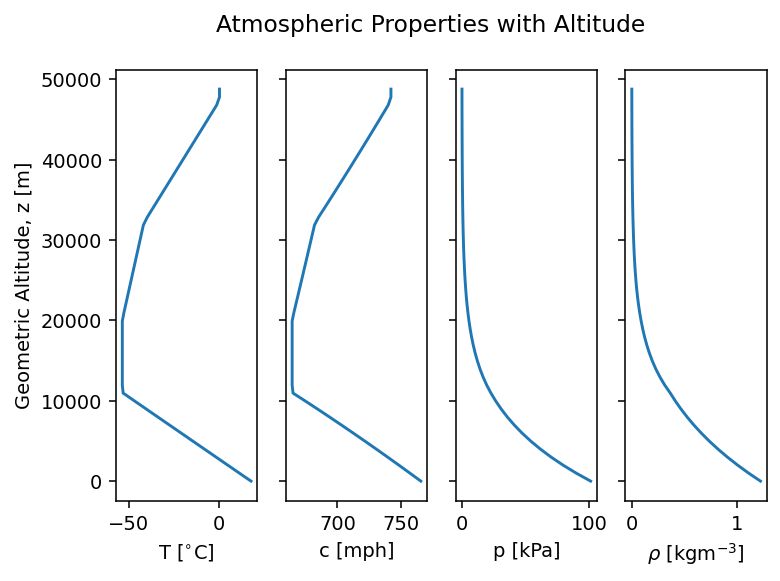

In [6]:
from carpy.utility import Quantity
import numpy as np
from matplotlib import pyplot as plt

# Independent data
z_altitude = Quantity(np.linspace(0, 160e3), "ft")

# Dependent data
temperature = myatmosphere.T(altitude=z_altitude, geometric=True)
speedosound = myatmosphere.c_sound(altitude=z_altitude, geometric=True)
pressure = myatmosphere.p(altitude=z_altitude, geometric=True)
density = myatmosphere.rho(altitude=z_altitude, geometric=True)

# Make a plot
fig, axs = plt.subplots(1, 4, dpi=140, figsize=(6, 4), sharey=True)
fig.suptitle("Atmospheric Properties with Altitude")

axs[0].plot(temperature.to("degC"), z_altitude)
axs[1].plot(speedosound.to("mi hr^{-1}"), z_altitude)
axs[2].plot(pressure.to("kPa"), z_altitude)
axs[3].plot(density, z_altitude)

axs[0].set_ylabel("Geometric Altitude, z [m]")
axs[0].set_xlabel("T [$^{\circ}$C]")
axs[1].set_xlabel("c [mph]")
axs[2].set_xlabel("p [kPa]")
axs[3].set_xlabel(r"$\rho$ [kgm$^{-3}$]")

plt.show()

***
## 2) `MILHDBK310` objects

`MILHDBK310` atmospheres do not instantiate the same way as `ISA1975` atmospheres do.
This is because there is no default MILHDBK310 atmosphere, rather it is a collection of observed atmospheres (stored in attributes of `MILHDBK310`).

In [7]:
from carpy.environment import MILHDBK310

# Create an atmosphere object
milatmos = MILHDBK310.HT5_1pct

print(milatmos)

MILHDBK310[HT5:1%]


The `MILHDBK310.HT5_1pct` atmosphere is the observed atmospheric profile for when the Earth's atmosphere had an unusually high temperature (1% highs) at ~ 5 km geometric altitude. A full list of atmospheres can be found by querying `MILHDBK310`:

In [8]:
print(", ".join([attr for attr in dir(MILHDBK310) if not attr.startswith("_")]))

HD10_10pct, HD10_1pct, HD20_10pct, HD20_1pct, HD30_10pct, HD30_1pct, HD40_10pct, HD40_1pct, HD5_10pct, HD5_1pct, HT10_10pct, HT10_1pct, HT20_10pct, HT20_1pct, HT30_10pct, HT30_1pct, HT40_10pct, HT40_1pct, HT5_10pct, HT5_1pct, LD10_10pct, LD10_1pct, LD20_10pct, LD20_1pct, LD30_10pct, LD30_1pct, LD40_10pct, LD40_1pct, LD5_10pct, LD5_1pct, LT10_10pct, LT10_1pct, LT20_10pct, LT20_1pct, LT30_10pct, LT30_1pct, LT40_10pct, LT40_1pct, LT5_10pct, LT5_1pct


Querying the values of a military handbook atmosphere is a very similar task to querying the international standard atmosphere, making plug'n'play very convenient:

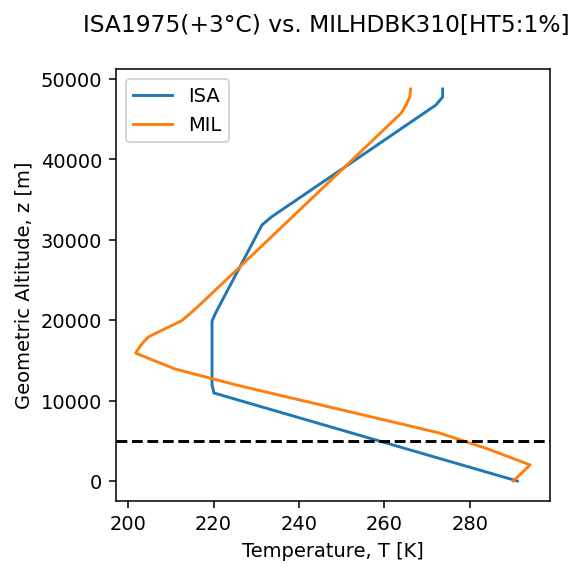

In [9]:
T_isa = temperature
T_mil = milatmos.T(altitude=z_altitude, geometric=True)

fig, ax = plt.subplots(1, dpi=140, figsize=(4, 4))
fig.suptitle(f"{myatmosphere} vs. {milatmos}")

ax.plot(T_isa.to("K"), z_altitude, label="ISA")
ax.plot(T_mil.to("K"), z_altitude, label="MIL")
ax.axhline(5e3, ls="--", c="k")

ax.set_ylabel("Geometric Altitude, z [m]")
ax.set_xlabel("Temperature, T [K]")

ax.legend()
plt.show()

Let's visualise how calibrated airspeed changes compared to equivalent airspeed with altitude:

Computing airspeeds...Done!


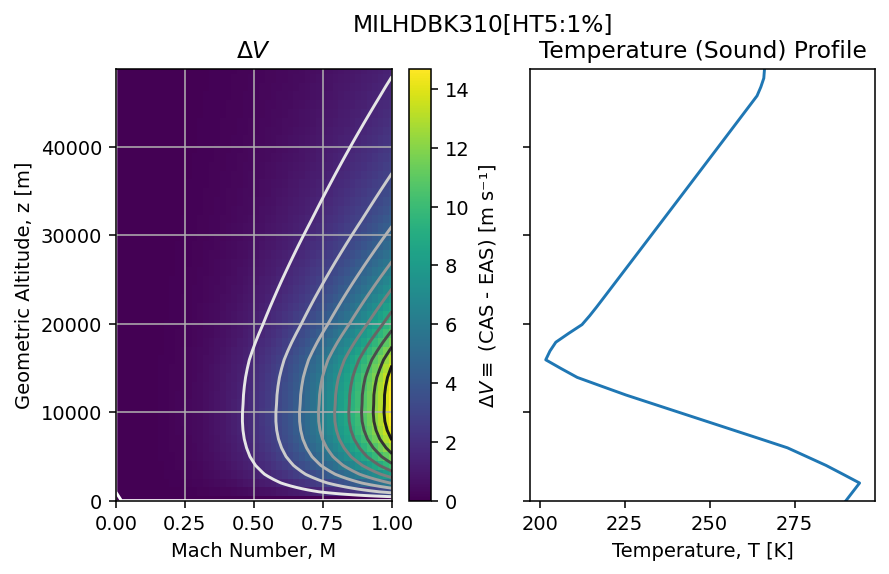

In [10]:
# Create 2d meshes of altitudes and Mach numbers to evaluate
Mach = np.linspace(0, 1)
mesh_alt, mesh_Mach = np.meshgrid(z_altitude, Mach)

print("Computing airspeeds...", end="")
cas, eas, tas, Mach = milatmos.airspeeds(altitude=mesh_alt, geometric=True, Mach=mesh_Mach)
print("Done!")

dv = cas - eas

# Create figure
fig, axs = plt.subplots(1, 2, dpi=140, figsize=(7, 4), sharey=True)
fig.suptitle(f"{milatmos}")

# Plot things
cm = axs[0].pcolormesh(mesh_Mach, mesh_alt, dv, cmap="viridis")
axs[0].contour(mesh_Mach, mesh_alt, dv, cmap="binary", levels=10)
fig.colorbar(cm, ax=axs[0], label="$\Delta V \equiv$ (CAS - EAS) "+f"[{dv.units}]")
axs[1].plot(T_mil, z_altitude)

axs[0].set_title("$\Delta V$")
axs[0].set_xlabel("Mach Number, M")
axs[0].set_ylabel("Geometric Altitude, z [m]")
axs[0].set_xlim(Mach.min(), Mach.max())
axs[0].set_ylim(z_altitude.min(), z_altitude.max())
axs[0].grid()

axs[1].set_title("Temperature (Sound) Profile")
axs[1].set_xlabel("Temperature, T [K]")
axs[1].set_ylim(z_altitude.min(), z_altitude.max())

plt.show() 

Notice that the deviation of calibrated airspeed from equivalent airspeed is strongest at higher speeds, indicating a relationship subject to compressibility effects.

***
## 3) `US1976` objects

***
## 4) `ObsAtmospherePerfect` objects

Custom atmospheric profiles can be defined by users using sequences of observed conditions:

In [11]:
from carpy.environment import ObsAtmospherePerfect

customatmos = ObsAtmospherePerfect(altitude=[0, 11_000], T=[288.15, 216.15])

We can compare the temperature profiles of our offset ISA and custom observed profile:

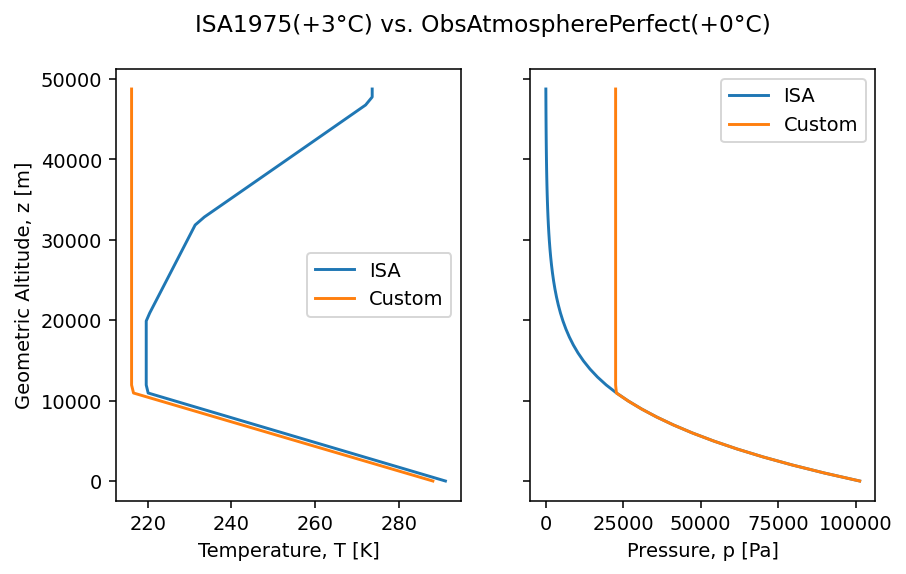

In [12]:
p_isa = myatmosphere.p(altitude=z_altitude, geometric=True)
T_cstm = customatmos.T(altitude=z_altitude, geometric=True)
p_cstm = customatmos.p(altitude=z_altitude, geometric=True)

fig, axs = plt.subplots(1, 2, dpi=140, figsize=(7, 4), sharey=True)
fig.suptitle(f"{myatmosphere} vs. {customatmos}")

axs[0].plot(T_isa.to("K"), z_altitude, label="ISA")
axs[0].plot(T_cstm.to("K"), z_altitude, label="Custom")
axs[1].plot(p_isa, z_altitude, label="ISA")
axs[1].plot(p_cstm, z_altitude, label="Custom")

axs[0].set_ylabel("Geometric Altitude, z [m]")
axs[0].set_xlabel("Temperature, T [K]")
axs[1].set_xlabel("Pressure, p [Pa]")

axs[0].legend()
axs[1].legend()
plt.show()

Notice how for undefined altitudes, the observed atmosphere is evaluated at altitudes with undefined pressure, temperature, and/or density conditions.
As a result, the atmospheric conditions of a custom atmosphere should be given for the relevant use-case altitudes.